### Consolidated notebook that plots hits and SiPM pmaps

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import cycle
import traceback

from glob import glob
from pathlib import Path
import os
import re
import sys
from tqdm import tqdm

sys.path.append("/gluster/data/next/software/IC_311024/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
#sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
os.environ['ICTDIR']='/gluster/data/next/software/IC_311024/'

from invisible_cities.io.dst_io        import df_writer
from invisible_cities.io.dst_io        import load_dst

from invisible_cities.cities.beersheba import cut_over_Q
from invisible_cities.cities.beersheba import drop_isolated 
from invisible_cities.io.pmaps_io import load_pmaps
from invisible_cities.io.pmaps_io import load_pmaps_as_df
from invisible_cities.database.load_db import DataPMT, DataSiPM
from invisible_cities.reco.peak_functions import rebin_times_and_waveforms


In [2]:
def raw_plotter(q, evt, pitch = 15.55):
    '''
    just plots the hits, nothing smart
    '''

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    xx = np.arange(q.X.min(), q.X.max() + pitch, pitch)
    yy = np.arange(q.Y.min(), q.Y.max() + pitch, pitch)
    zz = np.sort(q.Z.unique())

    axes[0].hist2d(q.X, q.Y, bins=[xx, yy], weights=q.Q, cmin=0.0001);
    axes[0].set_xlabel('X (mm)');
    axes[0].set_ylabel('Y (mm)');

    axes[1].hist2d(q.X, q.Z, bins=[xx, zz], weights=q.Q, cmin=0.0001);
    axes[1].set_xlabel('X (mm)');
    axes[1].set_ylabel('Z (mm)');


    axes[2].hist2d(q.Y, q.Z, bins=[yy, zz], weights=q.Q, cmin=0.0001);
    axes[2].set_xlabel('Y (mm)');
    axes[2].set_ylabel('Z (mm)');
    fig.suptitle("rebinned in Z")
    plt.show(fig)



### load in data

In [3]:
low_thr_files = glob('low_thr_10022026/*000[0-9]*')
low_thr_files  = sorted(low_thr_files, key=lambda f: int(re.search(r'_000(\d)_', f).group(1)))

low_thr_files_pmap = glob('low_thr_10022026_pmap/*000[0-9]*')
low_thr_files_pmap  = sorted(low_thr_files_pmap, key=lambda f: int(re.search(r'_000(\d)_', f).group(1)))

In [4]:
# load the old db
db = pd.read_csv('ChannelPosition_backup.csv')

In [5]:
# list of evts of interest
#evts = [177, 219, 737, 842, 849, 954, 1045, 1087, 1094]
evts = [86, 289, 310, 443]

In [6]:
thr_EOI = []
thr_EOI_pmap = []
for thr_file, pmap_file in tqdm(zip(low_thr_files, low_thr_files_pmap)):

    df_thr = load_dst(thr_file, 'RECO', 'Events')
    df_thr_pmap = load_pmaps(pmap_file)

    df_thr = df_thr[df_thr.event.isin(evts)]
    df_thr_pmap = {f'{x}' : df_thr_pmap[x] for x in df_thr_pmap if x in evts}
    
    thr_EOI.append(df_thr)
    thr_EOI_pmap.append(df_thr_pmap)
    # all our events are in the first file, and I'm too lazy to do this any better
    break
thr_EOI = pd.concat(thr_EOI)

0it [01:04, ?it/s]


In [7]:
# kill the screamer
print(thr_EOI.shape[0])
thr_EOI = thr_EOI[~((thr_EOI.X == 243.225) & (thr_EOI.Y == -340.975))]
print(thr_EOI.shape[0])

1225728
1225386


## define `cut_over_Q` and `drop_isolated` 

In [8]:
q_thr     = 7
drop_dist = [15.55, 15.55]

cut_sensors   = cut_over_Q(q_thr, ['E', 'Ec'])
drop_sensors  = drop_isolated(drop_dist, ['E', 'Ec'])


# select event of interest

In [9]:
evt = 289

No thresholds


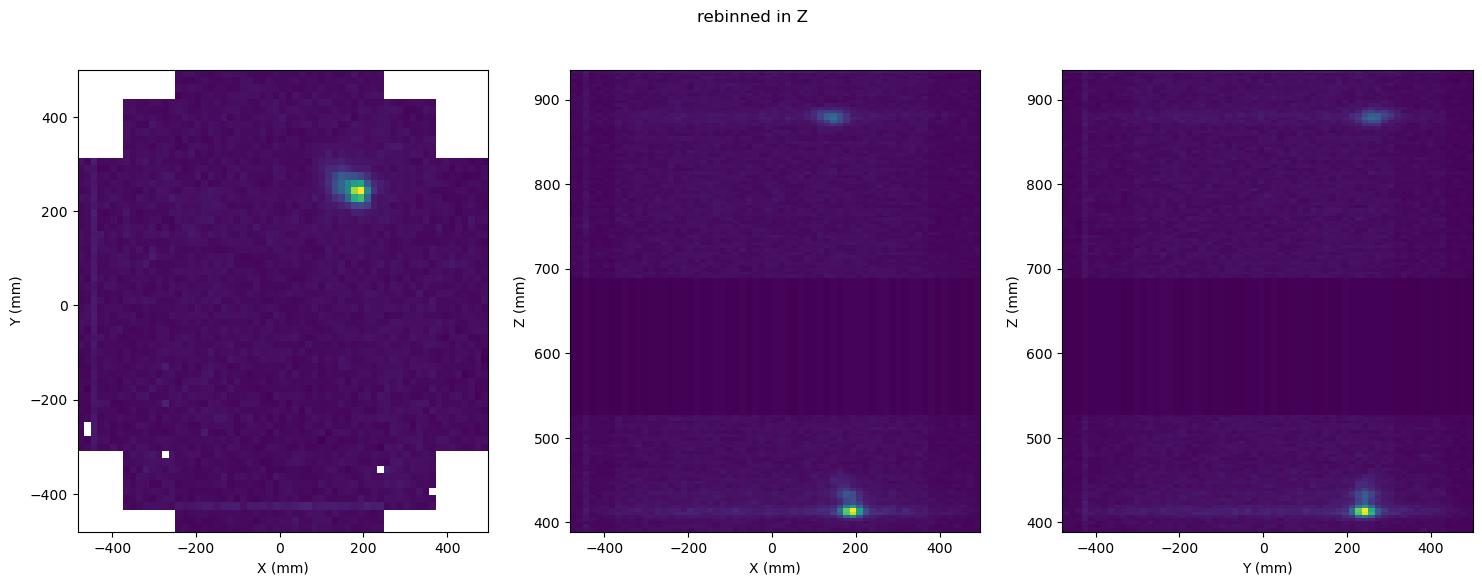

No thresholds with cut at 7


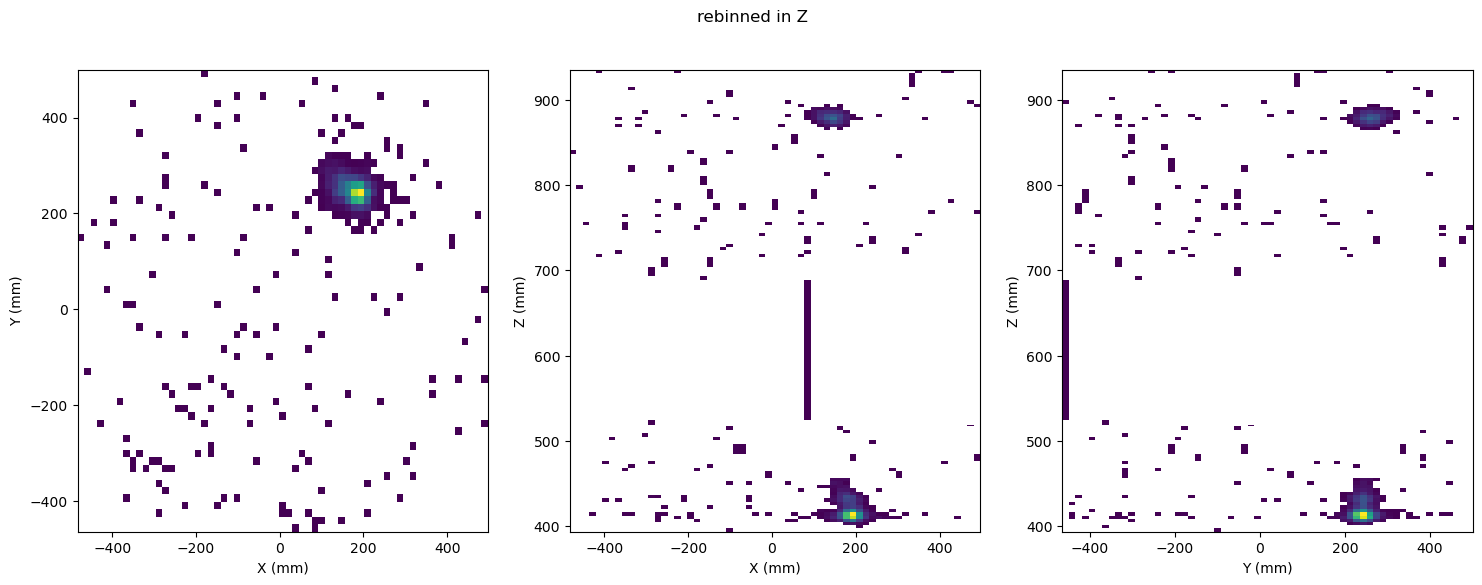

In [10]:
# plot the difference
thr_EOI_evt = thr_EOI[thr_EOI.event == evt]
print('No thresholds')
raw_plotter(thr_EOI_evt, evt)
print(f'No thresholds with cut at {q_thr}')
raw_plotter(cut_sensors(thr_EOI_evt), evt)

In [14]:
print('='*20)
print('hits')
print('='*20)

xy_array = thr_EOI[['X']].drop_duplicates().merge(thr_EOI[['Y']].drop_duplicates(), how = "cross").drop_duplicates()
display(xy_array)
print(thr_EOI.X.unique())
print('='*20)
print(thr_EOI.Y.unique())

hits


,X,Y
0,-482.625,-294.825
1,-482.625,-279.275
2,-482.625,-263.725
3,-482.625,-248.175
4,-482.625,-232.625
...,...,...
7675,490.025,430.525
7676,490.025,446.075
7677,490.025,461.625
7678,490.025,477.175


[-482.625 -467.075 -451.525 -435.975 -420.425 -404.875 -389.325 -373.775
 -359.225 -343.675 -328.125 -312.575 -297.025 -281.475 -265.925 -250.375
 -235.825 -220.275 -204.725 -189.175 -173.625 -158.075 -142.525 -126.975
 -112.425  -96.875  -81.325  -65.775  -50.225  -34.675  -19.125   -3.575
   10.975   26.525   42.075   57.625   73.175   88.725  104.275  119.825
  134.375  149.925  165.475  181.025  196.575  212.125  227.675  243.225
  257.775  273.325  288.875  304.425  319.975  335.525  351.075  366.625
  381.175  396.725  412.275  427.825  443.375  458.925  474.475  490.025]
[-294.825 -279.275 -263.725 -248.175 -232.625 -217.075 -201.525 -185.975
 -171.425 -155.875 -140.325 -124.775 -109.225  -93.675  -78.125  -62.575
  -48.025  -32.475  -16.925   -1.375   14.175   29.725   45.275   60.825
   75.375   90.925  106.475  122.025  137.575  153.125  168.675  184.225
  198.775  214.325  229.875  245.425  260.975  276.525  292.075  307.625
 -418.225 -402.675 -387.125 -371.575 -356.025 -340

In [83]:
x_val = -173.625

# check viable y parameters
display(np.sort(xy_array[xy_array.X == x_val].Y.unique()))
print(thr_EOI_evt[thr_EOI_evt.X == x_val].Y.unique())

array([-479.925, -464.375, -448.825, -433.275, -418.225, -417.725,
       -402.675, -402.175, -387.125, -386.625, -371.575, -371.075,
       -356.525, -356.025, -340.975, -340.475, -325.425, -324.925,
       -309.875, -309.375, -294.825, -294.325, -279.275, -278.775,
       -263.725, -263.225, -248.175, -247.675, -233.125, -232.625,
       -217.575, -217.075, -202.025, -201.525, -186.475, -185.975,
       -171.425, -170.925, -155.875, -155.375, -140.325, -139.825,
       -124.775, -124.275, -109.725, -109.225,  -94.175,  -93.675,
        -78.625,  -78.125,  -63.075,  -62.575,  -48.025,  -47.525,
        -32.475,  -31.975,  -16.925,  -16.425,   -1.375,   -0.875,
         13.675,   14.175,   29.225,   29.725,   44.775,   45.275,
         60.325,   60.825,   75.375,   75.875,   90.925,   91.425,
        106.475,  106.975,  122.025,  122.525,  137.075,  137.575,
        152.625,  153.125,  168.175,  168.675,  183.725,  184.225,
        198.775,  199.275,  214.325,  214.825,  229.875,  230.

[-479.925 -464.375 -448.825 -433.275 -417.725 -402.175 -386.625 -371.075
 -356.525 -340.975 -325.425 -309.875 -294.325 -278.775 -263.225 -247.675
 -233.125 -217.575 -202.025 -186.475 -170.925 -155.375 -139.825 -124.275
 -109.725  -94.175  -78.625  -63.075  -47.525  -31.975  -16.425   -0.875
   13.675   29.225   44.775   60.325   75.875   91.425  106.975  122.525
  137.075  152.625  168.175  183.725  199.275  214.825  230.375  245.925
  260.475  276.025  291.575  307.125  322.675  338.225  353.775  369.325
  383.875  399.425  414.975  430.525  446.075  461.625  477.175  492.725]


In [84]:
# choose an xy pair that exists here
thr_list = list(zip(thr_EOI_evt.X.values, thr_EOI_evt.Y.values))

y_val = -263.225

df_thr_xy = thr_EOI_evt[(thr_EOI_evt.X == x_val) & (thr_EOI_evt.Y == y_val)]
if df_thr_xy.empty:
    print('Choose a differing xy! Theres nothing in this one')
else:
    display(df_thr_xy)

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
4588390,289,1.746555e+09,11,33.224697,43.863160,1,-173.625,-263.225,0.0,0.0,388.840250,0.181425,-0.001058,-1.0,-1.0,-1,-1.0
4591974,289,1.746555e+09,11,33.224697,43.863160,1,-173.625,-263.225,0.0,0.0,393.708875,0.181425,0.000558,-1.0,-1.0,-1,-1.0
4595558,289,1.746555e+09,11,33.224697,43.863160,1,-173.625,-263.225,0.0,0.0,397.700875,0.060475,0.011201,-1.0,-1.0,-1,-1.0
4599142,289,1.746555e+09,11,33.224697,43.863160,1,-173.625,-263.225,0.0,0.0,401.423625,0.060475,0.096690,-1.0,-1.0,-1,-1.0
4602726,289,1.746555e+09,11,33.224697,43.863160,1,-173.625,-263.225,0.0,0.0,405.154500,0.241899,0.980322,-1.0,-1.0,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4925286,289,1.746555e+09,14,11.440432,17.648083,1,-173.625,-263.225,0.0,0.0,919.149875,2.237569,0.013835,-1.0,-1.0,-1,-1.0
4928870,289,1.746555e+09,14,11.440432,17.648083,1,-173.625,-263.225,0.0,0.0,923.953375,0.302374,0.000056,-1.0,-1.0,-1,-1.0
4932454,289,1.746555e+09,14,11.440432,17.648083,1,-173.625,-263.225,0.0,0.0,927.382625,0.060475,-0.000130,-1.0,-1.0,-1,-1.0
4936038,289,1.746555e+09,14,11.440432,17.648083,1,-173.625,-263.225,0.0,0.0,931.327500,0.241899,-0.000932,-1.0,-1.0,-1,-1.0


Charge sum 113.57176595181227


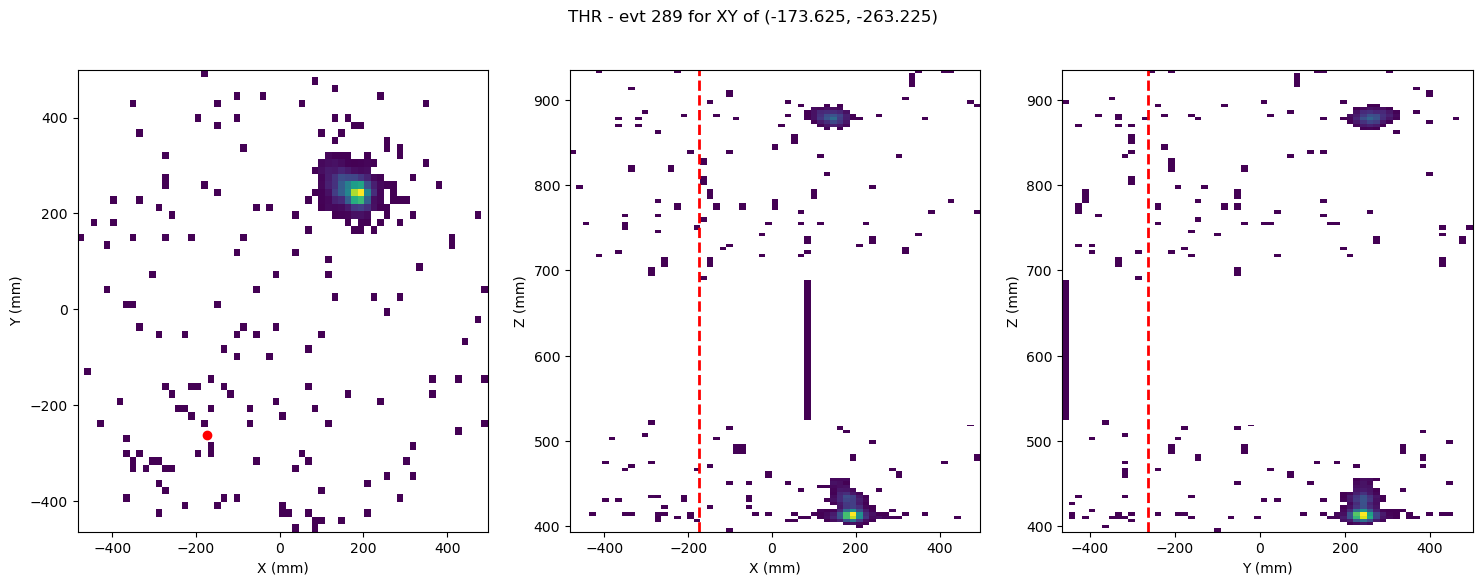

In [85]:
# visualise xy choice

print(f'Charge sum {df_thr_xy.Q.sum()}')

q = cut_sensors(thr_EOI_evt)
pitch = 15.55
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

xx = np.arange(q.X.min(), q.X.max() + pitch, pitch)
yy = np.arange(q.Y.min(), q.Y.max() + pitch, pitch)
zz = np.sort(q.Z.unique())

axes[0].hist2d(q.X, q.Y, bins=[xx, yy], weights=q.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[0].scatter(x_val, y_val, c = 'red')

axes[1].hist2d(q.X, q.Z, bins=[xx, zz], weights=q.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[1].axvline(x=x_val, color='red', linestyle='--', linewidth=2) 

axes[2].hist2d(q.Y, q.Z, bins=[yy, zz], weights=q.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');
axes[2].axvline(x=y_val, color='red', linestyle='--', linewidth=2) 

fig.suptitle(f"THR - evt {q.event.unique()[0]} for XY of {x_val, y_val}")
plt.show(fig)


# extract db index with hits

selected npeak of 11


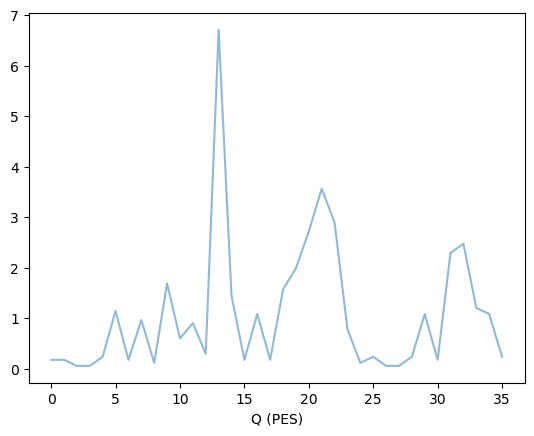

In [86]:
# select the npeak in your hits
npeak_OI = df_thr_xy.npeak.unique()[0]
df_thr_xy_npeak = df_thr_xy[df_thr_xy.npeak == npeak_OI]

print(f'selected npeak of {npeak_OI}')
plt.plot(df_thr_xy_npeak.Q.values, label = 'Hits', alpha = 0.5)
plt.xlabel('Q (PES)')
plt.show()

In [87]:
# hunt down the equivalent pmap
for i, wf_wow in enumerate(df_thr_pmap[str(evt)].s2s[npeak_OI].sipms.all_waveforms):
    times_mod = df_thr_pmap[str(evt)].s2s[npeak_OI].times/1e3
    width_mod = np.zeros(len(wf_wow))

    times_mod, width_mod, wf_wow = rebin_times_and_waveforms(times_mod, width_mod, wf_wow[np.newaxis], rebin_stride = 4)
    if np.isclose(wf_wow[0], df_thr_xy_npeak.Q.values).all():
        print(f"We have a winner!")
        print(f'sensor id {i}')
        sens_id = i
        break

We have a winner!
sensor id 870


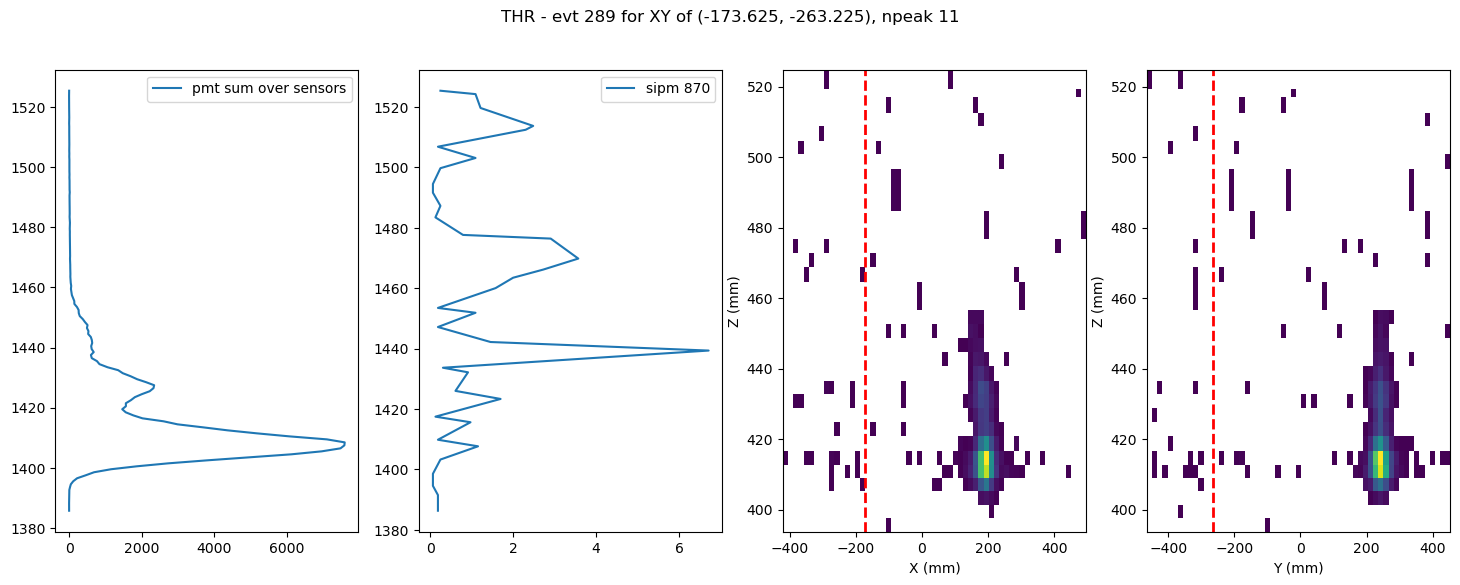

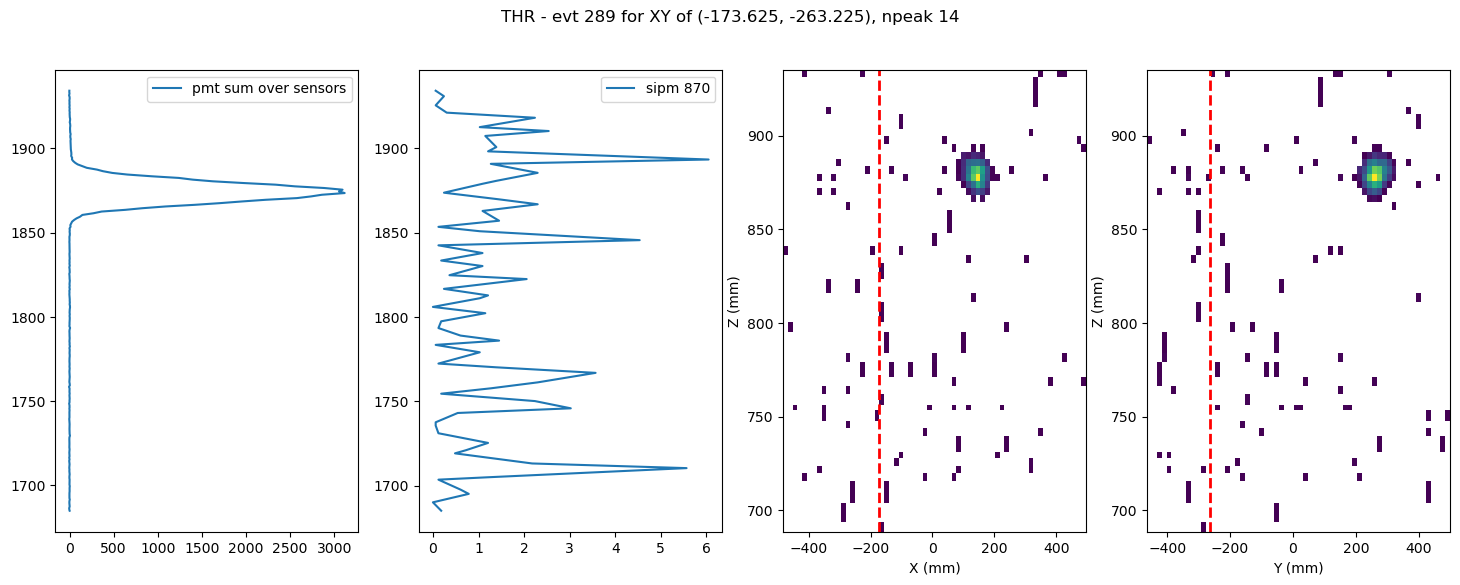

In [89]:
# plot each npeak wrt its sipms and pmts
for npeak, evt_hits in q.groupby('npeak'):
    
    fig, axes = plt.subplots(1, 4, figsize=(18, 6))
    # binning
    xx = np.arange(evt_hits.X.min(), evt_hits.X.max() + pitch, pitch)
    yy = np.arange(evt_hits.Y.min(), evt_hits.Y.max() + pitch, pitch)
    zz = np.sort(evt_hits.Z.unique())
    
    # rebin
    times_mod = df_thr_pmap[str(evt)].s2s[npeak].times/1e3
    wf_mod    = df_thr_pmap[str(evt)].s2s[npeak].sipms.waveform(sensor_id = sens_id)
    #wf_mod    = df_thr_pmap[str(evt)].s2s[npeak].sipms.sum_over_sensors
    width_mod = np.zeros(len(wf_mod))
    times_mod, width_mod, wf_mod = rebin_times_and_waveforms(times_mod, width_mod, wf_mod[np.newaxis], rebin_stride = 4)
    
    
    
    axes[1].plot(wf_mod[0], times_mod, label = f'sipm {sens_id}')
    axes[1].legend()
    #axes[1].plot(df_thr_pmap[evt].s2s[npeak].sipms.waveform(sensor_id = sens_id), df_thr_pmap[evt].s2s[npeak].times/1e3, label = 'pmt sum over sensors')
    
    #axes[1].scatter(x_val, y_val, c = 'red')

    axes[2].hist2d(evt_hits.X, evt_hits.Z, bins=[xx, zz], weights=evt_hits.Q, cmin=0.0001);
    axes[2].set_xlabel('X (mm)');
    axes[2].set_ylabel('Z (mm)');

    axes[2].axvline(x=x_val, color='red', linestyle='--', linewidth=2) 

    axes[3].hist2d(evt_hits.Y, evt_hits.Z, bins=[yy, zz], weights=evt_hits.Q, cmin=0.0001);
    axes[3].set_xlabel('Y (mm)');
    axes[3].set_ylabel('Z (mm)');
    axes[3].axvline(x=y_val, color='red', linestyle='--', linewidth=2) 
    # extract the s2 related to the hits, plot on the 0th axis
    axes[0].plot(df_thr_pmap[str(evt)].s2s[npeak].pmts.sum_over_sensors, df_thr_pmap[str(evt)].s2s[npeak].times/1e3, label = 'pmt sum over sensors')
    axes[0].legend()
    
# visualise the differing s2s

#for enum, (minima, maxima) in enumerate(zip(mins, maxes)):
#    print(f'Min max bands of:\n{minima}, {maxima}')
#    col = next(colour_cycle)
#    axes[1].axhspan(minima, maxima, alpha=0.3, color = col, label = s2s_of_interest[enum])
#    axes[2].axhspan(minima, maxima, alpha=0.3, color = col)

    
    fig.suptitle(f"THR - evt {evt_hits.event.unique()[0]} for XY of {x_val, y_val}, npeak {npeak}")
    plt.show(fig)
